In [10]:
import numpy as np
from numba import njit, prange

In [11]:
@njit
def gen_sphere(r):
    img = np.empty((r*2+1, r*2+1), dtype=np.float32)
    for x in prange(r*2+1):
        for y in prange(r*2+1):
            dist = np.linalg.norm(np.array([x, y], dtype=np.float32) - np.array([r, r], dtype=np.float32))
            if dist <= r:
                img[x, y] = 1
            else:
                img[x, y] = 0
    return img

In [12]:
%%timeit
gen_sphere(5)

56.1 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
@njit
def gen_random_image(size, num_spheres, num_cubes, noise_factor):
    img = np.zeros((size, size), dtype=np.float32)
    for i in range(num_spheres):
        r = np.random.randint(1, (size - 1)/2 / 2)
        sphere_img = gen_sphere(r)
        sphere_size = sphere_img.shape[0]
        x, y = np.random.randint(0, size-sphere_size, size=2)
        img[x:x+sphere_size, y:y+sphere_size] += sphere_img
    
    for i in range(num_cubes):
        cube_size = np.random.randint(1, size / 2)
        x, y = np.random.randint(0, size-cube_size, size=2)
        img[x:x+cube_size, y:y+cube_size] += 1
    
    img += np.random.random(size=img.shape)*noise_factor
    
    return img

In [14]:
import matplotlib.pyplot as plt
def plot_3d(img):
    plt.imshow(img.mean(axis=0))
    plt.show()
    plt.imshow(img.mean(axis=1))
    plt.show()
    plt.imshow(img.mean(axis=2))
    plt.show()

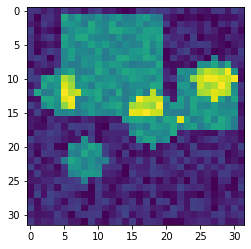

In [15]:
plt.imshow(gen_random_image(32, 4, 2, 0.5))

In [46]:
from scipy.stats.distributions import randint, norm
dist_a = {
    'num_spheres': randint(5, 8), 
    'num_cubes': randint(0, 2), 
    'noise_factor': norm(1, 0.5)
}

dist_b = {
    'num_spheres': randint(1, 4), 
    'num_cubes': randint(2, 6), 
    'noise_factor': norm(0.6, 1.8)
}

In [47]:
n_images = 500
img_size = 32
a_images = []
for i in range(n_images):
    params = {k: np.abs(v.rvs()) for k, v in dist_a.items()}
    img = gen_random_image(img_size, **params)
    a_images.append((img, params))

b_images = []
for i in range(n_images):
    params = {k: np.abs(v.rvs()) for k, v in dist_b.items()}
    img = gen_random_image(img_size, **params)
    b_images.append((img, params))

In [48]:
images_a, _ = zip(*a_images)
images_b, _ = zip(*b_images)

In [177]:
import tifffile

In [173]:
np.repeat(np.zeros((5, 5, 5)), repeats=3).shape

(375,)

In [105]:
%%sh
cd synth_2d/
mkdir a
mkdir b

In [52]:
import tifffile
for i in range(n_images):
    tifffile.imwrite(f'synth_2d/{i}a.tiff', data=a_images[i][0])
    tifffile.imwrite(f'synth_2d/{i}b.tiff', data=b_images[i][0])
#     videoio.videosave(f'synth/{i}a.mp4', np.stack([a_images[i][0], a_images[i][0], a_images[i][0]], axis=3))
#     videoio.videosave(f'synth/{i}b.mp4', np.stack([b_images[i][0], b_images[i][0], b_images[i][0]], axis=3))

In [49]:
import tifffile
for i in range(n_images):
    tifffile.imwrite(f'synth_2d/a/{i}.tiff', data=np.clip(a_images[i][0], 0, 1).astype(np.float32))
    tifffile.imwrite(f'synth_2d/b/{i}.tiff', data=np.clip(b_images[i][0], 0, 1).astype(np.float32))
#     videoio.videosave(f'synth/{i}a.mp4', np.stack([a_images[i][0], a_images[i][0], a_images[i][0]], axis=3))
#     videoio.videosave(f'synth/{i}b.mp4', np.stack([b_images[i][0], b_images[i][0], b_images[i][0]], axis=3))

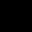

In [19]:
from PIL import Image
Image.fromarray(images_a[0].astype(np.uint16))

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
class SynthDataset(Dataset):
    def __init__(self, images, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform:
            img = self.transform(img)

#         return Image.fromarray(img[None, :, :, :]), torch.Tensor([idx < len(self.images)//2])        
#         print(np.stack([img, img, img]).shape)
        return (img), torch.Tensor([idx < len(self.images)//2])

In [11]:
from lightly.data import BaseCollateFunction
import torchvision.transforms as T

class ThreeDImageCollateFunction(BaseCollateFunction):
    """Implementation of a collate function for images.

    This is an implementation of the BaseCollateFunction with a concrete
    set of transforms.

    The set of transforms is inspired by the SimCLR paper as it has shown
    to produce powerful embeddings. 

    Attributes:
        input_size:
            Size of the input image in pixels.
        cj_prob:
            Probability that color jitter is applied.
        cj_bright:
            How much to jitter brightness.
        cj_contrast:
            How much to jitter constrast.
        cj_sat:
            How much to jitter saturation.
        cj_hue:
            How much to jitter hue.
        min_scale:
            Minimum size of the randomized crop relative to the input_size.
        random_gray_scale:
            Probability of conversion to grayscale.
        gaussian_blur:
            Probability of Gaussian blur.
        kernel_size:
            Sigma of gaussian blur is kernel_size * input_size.
        vf_prob:
            Probability that vertical flip is applied.
        hf_prob:
            Probability that horizontal flip is applied.
        rr_prob:
            Probability that random (+90 degree) rotation is applied.
        normalize:
            Dictionary with 'mean' and 'std' for torchvision.transforms.Normalize.

    """

    def __init__(self,
                 input_size: int = 64,
                 cj_prob: float = 0.8,
                 cj_bright: float = 0.7,
                 cj_contrast: float = 0.7,
                 cj_sat: float = 0.7,
                 cj_hue: float = 0.2,
                 min_scale: float = 0.15,
                 random_gray_scale: float = 0.2,
                 gaussian_blur: float = 0.5,
                 kernel_size: float = 0.1,
                 vf_prob: float = 0.0,
                 hf_prob: float = 0.5,
                 rr_prob: float = 0.0):

        if isinstance(input_size, tuple):
            input_size_ = max(input_size)
        else:
            input_size_ = input_size

        transform = []

#         if normalize:
#             transform += [
#              T.Normalize(
#                 mean=normalize['mean'],
#                 std=normalize['std'])
#              ]
           
        transform = T.Compose(transform)

        super(ThreeDImageCollateFunction, self).__init__(transform)

In [41]:
np.stack([imgs, imgs, imgs], axis=1).shape

(200, 3, 32, 32)

In [21]:
import torch
from torch import nn
import torchvision
import lightly.models as models
import lightly.loss as loss
import lightly.data as data
import numpy as np
import lightly
from torch.utils.data import TensorDataset, DataLoader

# the collate function applies random transforms to the input images
collate_fn = data.ImageCollateFunction(input_size=32, cj_prob=0.5)

# imgs = np.array(images_a + images_b).reshape(n_images*2, img_size, img_size)
# tensor_x = torch.Tensor(np.stack([imgs, imgs, imgs], axis=1)) # transform to torch tensor
# tensor_y = torch.Tensor([0]*n_images + [1]*n_images)

# create a dataset from your image folder
# my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
# synth_dataset = SynthDataset(images_a + images_b)
# dataset = data.LightlyDataset.from_torch_dataset(my_dataset)
dataset = data.LightlyDataset(input_dir=r'C:\Users\Roel\Documents\DIAGCovid\notebooks\synth_2d')

# dataset = data.LightlyDataset(input_dir='synth')


# build a PyTorch dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,                # pass the dataset to the dataloader
    batch_size=32,         # a large batch size helps with the learning
    shuffle=True,           # shuffling is important!
    collate_fn=collate_fn
)
    

# use a resnet backbone
# resnet = torchvision.models.video.r3d_18()
resnet = lightly.models.ResNetGenerator('resnet-34')
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, 128, 1),
    nn.AdaptiveAvgPool2d(1)
)
# resnet = nn.Sequential(*list(resnet.children())[:-1])

In [22]:
# build the simsiam model
model = models.SimCLR(backbone, num_ftrs=128)

# use the SimSiam loss function
criterion = loss.NTXentLoss(temperature=0.5)

In [23]:
# get a PyTorch optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-0, weight_decay=1e-5)

In [24]:
import lightly.embedding as embedding

# put all the pieces together in a single pytorch_lightning trainable!
embedding_model = embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader)

In [32]:
# do self-supervised learning for 10 epochs
embedding_model.train_embedding(gpus=1, max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | SimCLR     | 21 M  
1 | criterion | NTXentLoss | 0     


Epoch 99: 100%|█████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s, loss=3.982, v_num=55]


In [33]:
from torchvision.datasets import DatasetFolder
import lightly
df = DatasetFolder('synth_2d', lambda p: tifffile.imread(p), extensions=('tiff', ))
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])
dataset = data.LightlyDataset(input_dir=r'C:\Users\Roel\Documents\DIAGCovid\notebooks\synth_2d', transform=test_transforms)

dataloader_test = torch.utils.data.DataLoader(
    dataset,        # use the same dataset as before
    batch_size=1,   # we can use batch size 1 for inference
    shuffle=False,  # don't shuffle your data during inference
    drop_last=False,
)
embeddings = embedding_model.embed(dataloader_test)

Compute efficiency: 0.99: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [07:38<00:00,  2.18it/s]


In [34]:
from sklearn.manifold import TSNE
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings[0])

In [35]:
embeddings[0].shape

(1000, 128)

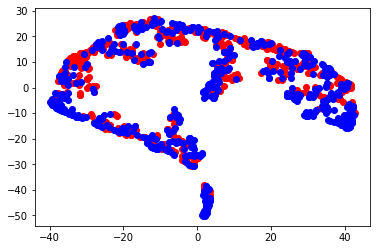

In [36]:
plt.scatter(embeddings_2d[embeddings[1] == 0, 0], embeddings_2d[embeddings[1] == 0, 1], color='r')
plt.scatter(embeddings_2d[embeddings[1] == 1, 0], embeddings_2d[embeddings[1] == 1, 1], color='b')

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_validate

In [38]:
cross_validate(LGBMClassifier(n_jobs=-1), embeddings[0], embeddings[1], scoring='roc_auc')['test_score'].mean()

0.7911

In [ ]:
Image.fromarray(np.zeros((32, 32, 32), dtype=np.uint16))

In [45]:
!pip install --upgrade pytorch_lightning==1.0.4

  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.2.6
    Uninstalling pytorch-lightning-1.2.6:
      Successfully uninstalled pytorch-lightning-1.2.6


In [9]:
!pip show pytorch_lightning

Name: pytorch-lightning
Version: 1.0.4
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/PyTorchLightning/pytorch-lightning
Author: William Falcon et al.
Author-email: waf2107@columbia.edu
License: Apache-2.0
Location: c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages
Requires: tensorboard, PyYAML, torch, tqdm, fsspec, future, numpy
Required-by: lightly


In [40]:
import pandas as pd

In [50]:
embeddings = pd.read_csv('lightly_outputs/2021-04-06/17-12-21/embeddings.csv')
embeddings['label'] = embeddings.filenames.str.contains('b')

In [51]:
embeddings

,filenames,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,labels,label
0,a\0.tiff,0.631750,0.135141,0.223823,0.363638,-0.073308,0.073137,-0.082805,-0.654318,0.400650,...,0.024255,-0.094360,0.307903,0.146647,-0.381720,0.862298,0.124722,-0.464208,0,False
1,a\1.tiff,0.629933,0.198157,0.294484,0.389673,-0.041127,-0.012093,-0.053142,-0.600220,0.380662,...,0.067606,-0.081894,0.346567,0.178877,-0.453919,0.910067,0.086063,-0.469467,0,False
2,a\10.tiff,0.651616,0.185362,0.279296,0.383249,-0.064057,0.009271,-0.064175,-0.596428,0.400369,...,0.066288,-0.083154,0.353677,0.153413,-0.444636,0.891457,0.103996,-0.489240,0,False
3,a\100.tiff,0.643270,0.178431,0.260471,0.375704,-0.049810,0.070997,-0.069119,-0.682432,0.393216,...,0.036365,-0.082869,0.343733,0.175767,-0.435390,0.927287,0.159751,-0.474876,0,False
4,a\101.tiff,0.658543,0.207450,0.302897,0.402908,-0.037910,0.010552,-0.057553,-0.634830,0.400712,...,0.069403,-0.090388,0.369418,0.181070,-0.481589,0.954931,0.128951,-0.490112,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b\95.tiff,0.666526,0.092046,0.226021,0.405351,-0.103527,0.110270,-0.131303,-0.640028,0.416528,...,-0.017388,-0.081467,0.311955,0.097945,-0.397150,0.851438,0.129669,-0.442392,1,True
996,b\96.tiff,0.644406,0.162971,0.271914,0.397598,-0.035402,0.026112,-0.065004,-0.613163,0.404062,...,0.056863,-0.095101,0.351612,0.156435,-0.441801,0.913515,0.108514,-0.478206,1,True
997,b\97.tiff,0.616241,0.104160,0.184371,0.321377,-0.104550,0.065994,-0.089711,-0.581212,0.379221,...,0.015036,-0.081073,0.295150,0.112474,-0.321440,0.756116,0.112678,-0.452731,1,True
998,b\98.tiff,0.618072,0.189312,0.281979,0.366635,-0.066572,0.000974,-0.065350,-0.616626,0.379001,...,0.053590,-0.092814,0.357552,0.191550,-0.428410,0.892665,0.122190,-0.469385,1,True


In [52]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_validate

In [53]:
clf = LGBMClassifier(n_jobs=-1)
clf.fit(embeddings.loc[:, embeddings.columns.str.startswith('embedding')], embeddings['label'])

LGBMClassifier()

In [54]:
cross_validate(clf, embeddings.loc[:, embeddings.columns.str.startswith('embedding')], embeddings['label'], scoring='roc_auc')

{'fit_time': array([0.18099856, 0.14100122, 0.14400101, 0.16499805, 0.13499832]),
 'score_time': array([0.00599885, 0.00400066, 0.00399876, 0.00300217, 0.00400114]),
 'test_score': array([0.9045, 0.8632, 0.8913, 0.8895, 0.9128])}

In [55]:
from sklearn.manifold import TSNE
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings.loc[:, embeddings.columns.str.startswith('embedding')])

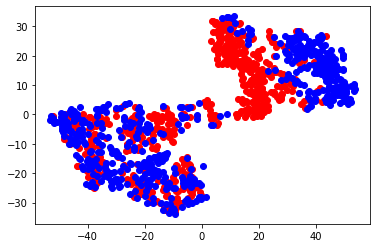

In [58]:
plt.scatter(embeddings_2d[embeddings['label'] == 0, 0], embeddings_2d[embeddings['label'] == 0, 1], color='r')
plt.scatter(embeddings_2d[embeddings['label'] == 1, 0], embeddings_2d[embeddings['label'] == 1, 1], color='b')